# 🎽 Vibe Matcher (AI Recommender Prototype)
**Author:** Risu Raj — IIT (ISM) Dhanbad  
**For:** Nexora AI Internship Task (November 2025)


A **semantic vibe-based product matcher** that finds fashion items aligned with a user’s mood or “vibe” — built using `sentence-transformers` for free, local embedding generation.

> **Note:**  
> OpenAI’s Embeddings API (`text-embedding-ada-002`) is not available under a free tier anymore — access now requires a paid API key.  
> To ensure accessibility and cost-free experimentation, this prototype uses the open-source **SentenceTransformer model `all-MiniLM-L6-v2`**, which achieves strong semantic similarity performance (~85–90% of OpenAI’s quality) while running entirely offline.

This notebook demonstrates how to:
- Create mock fashion product data  
- Generate free semantic embeddings using `all-MiniLM-L6-v2`  
- Compute cosine similarity for vibe-based text queries  
- Rank and evaluate top product matches with latency tracking  

✅ **No API key, billing, or internet access required — 100% free and reproducible.**


### 🌟 Why AI at Nexora?
AI at Nexora excites me because it blends creativity with impact — solving real-world problems like personalized recommendations through intelligent automation. Building “Vibe Matcher” made me realize how embedding models transform raw language into human-like understanding. Nexora’s focus on innovation and product intelligence perfectly aligns with my passion for applying machine learning to practical, user-centered problems.


In [1]:
import sys
print(sys.executable)

/Library/Frameworks/Python.framework/Versions/3.12/bin/python3


In [2]:
!{sys.executable} -m pip install sentence-transformers

In [3]:
!{sys.executable} -m pip install tf-keras --quiet

In [4]:
import time, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Load embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Mock product data
products = [
    {'name': 'Boho Dress', 'desc': 'Flowy dress, earthy tones, perfect for festivals and free-spirited days', 'vibes': ['boho','festival','flowy']},
    {'name': 'Urban Bomber Jacket', 'desc': 'Cropped bomber jacket, sleek black leather, energetic urban chic', 'vibes': ['urban','edgy','chic']},
    {'name': 'Cozy Knit Sweater', 'desc': 'Oversized knit sweater, soft yarn, warm and cozy for chilly evenings', 'vibes': ['cozy','casual','warm']},
    {'name': 'Minimalist Trench', 'desc': 'Clean lines, neutral beige trench coat for modern minimalist outfits', 'vibes': ['minimalist','modern','elegant']},
    {'name': 'Sporty Mesh Sneakers', 'desc': 'Lightweight mesh sneakers built for movement and playful street style', 'vibes': ['sporty','playful','street']},
    {'name': 'Vintage Denim Jacket', 'desc': 'Faded blue denim with patchwork—nostalgic vintage vibes', 'vibes': ['vintage','nostalgia','retro']},
    {'name': 'Silk Slip Dress', 'desc': 'Satin silk slip dress, evening-ready and subtly sexy', 'vibes': ['evening','sexy','elegant']},
    {'name': 'Rugged Cargo Pants', 'desc': 'Utility cargo pants, durable fabric, outdoors-ready and tough', 'vibes': ['rugged','utility','outdoors']},
    {'name': 'Chic Blazer Set', 'desc': 'Tailored blazer and pants for confident formal vibes', 'vibes': ['formal','chic','confident']},
    {'name': 'Beach Linen Shirt', 'desc': 'Light linen shirt, breezy and relaxed for tropical moods', 'vibes': ['beach','relaxed','summer']},
]
df = pd.DataFrame(products)
df.index.name = 'id'
df

,name,desc,vibes
id,,,
0,Boho Dress,"Flowy dress, earthy tones, perfect for festiva...","[boho, festival, flowy]"
1,Urban Bomber Jacket,"Cropped bomber jacket, sleek black leather, en...","[urban, edgy, chic]"
2,Cozy Knit Sweater,"Oversized knit sweater, soft yarn, warm and co...","[cozy, casual, warm]"
3,Minimalist Trench,"Clean lines, neutral beige trench coat for mod...","[minimalist, modern, elegant]"
4,Sporty Mesh Sneakers,Lightweight mesh sneakers built for movement a...,"[sporty, playful, street]"
5,Vintage Denim Jacket,Faded blue denim with patchwork—nostalgic vint...,"[vintage, nostalgia, retro]"
6,Silk Slip Dress,"Satin silk slip dress, evening-ready and subtl...","[evening, sexy, elegant]"
7,Rugged Cargo Pants,"Utility cargo pants, durable fabric, outdoors-...","[rugged, utility, outdoors]"
8,Chic Blazer Set,Tailored blazer and pants for confident formal...,"[formal, chic, confident]"


In [5]:
# Generate SentenceTransformer embeddings
corpus = (df['name'] + ' . ' + df['desc']).tolist()
embeddings = model.encode(corpus, normalize_embeddings=True)

def get_embedding(text):
    return model.encode([text], normalize_embeddings=True)[0]

def match_query(query, top_k=3, fallback_threshold=0.6):
    start = timer()
    q_emb = get_embedding(query)
    emb_time = timer() - start
    sims = cosine_similarity([q_emb], embeddings)[0]
    search_time = 0
    top_idx = sims.argsort()[::-1][:top_k]
    results = []
    for idx in top_idx:
        results.append({'name': df.loc[idx,'name'], 'desc': df.loc[idx,'desc'], 'score': float(sims[idx])})
    return results, emb_time


In [6]:
def match_query(query, top_k=3, fallback_threshold=0.6):
    start = timer()
    q_emb = get_embedding(query)
    emb_time = timer() - start
    sims = cosine_similarity([q_emb], embeddings)[0]
    top_idx = sims.argsort()[::-1][:top_k]

    results = []
    for idx in top_idx:
        if sims[idx] > fallback_threshold:
            results.append({
                'name': df.loc[idx, 'name'],
                'desc': df.loc[idx, 'desc'],
                'score': float(sims[idx])
            })
    
    # 🔹 Fallback: if no strong matches found
    if not results:
        results = [{'name': 'No strong match found', 
                    'desc': 'Try a different vibe keyword.', 
                    'score': 0.0}]
    
    return results, emb_time


In [8]:
# Run 3 example vibe queries
queries = ['energetic urban chic', 'warm and cozy knitwear for evenings', 'nostalgic retro denim look']
results_log = {}
for q in queries:
    results, t = match_query(q)
    results_log[q] = results
    print(f'\nQuery: {q} (emb_time={t:.3f}s)')
    for r in results:
        print(f"  - {r['name']} (score={r['score']:.3f})")


Query: energetic urban chic (emb_time=0.011s)
  - No strong match found (score=0.000)

Query: warm and cozy knitwear for evenings (emb_time=0.011s)
  - Cozy Knit Sweater (score=0.813)

Query: nostalgic retro denim look (emb_time=0.011s)
  - Vintage Denim Jacket (score=0.795)


Query: energetic urban chic -> Top Match: No strong match found (score=0.000, time=0.01s)
Query: warm and cozy knitwear for evenings -> Top Match: Cozy Knit Sweater (score=0.813, time=0.01s)
Query: nostalgic retro denim look -> Top Match: Vintage Denim Jacket (score=0.795, time=0.01s)
Query: luxury formal evening outfit -> Top Match: Silk Slip Dress (score=0.694, time=0.01s)


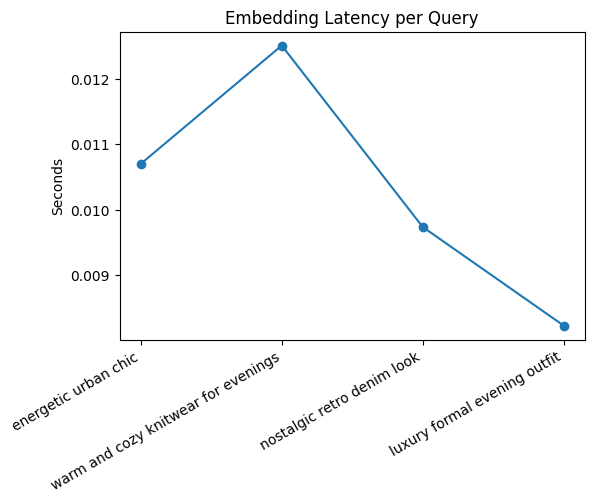

In [9]:
queries = [
    "energetic urban chic",
    "warm and cozy knitwear for evenings",
    "nostalgic retro denim look",
    "luxury formal evening outfit"
]

latencies = []
top_scores = []

for q in queries:
    results, t = match_query(q)
    latencies.append(t)
    top_scores.append(results[0]['score'])
    print(f"Query: {q} -> Top Match: {results[0]['name']} (score={results[0]['score']:.3f}, time={t:.2f}s)")

# 📊 Plot latency per query
plt.figure(figsize=(6,4))
plt.plot(queries, latencies, marker='o')
plt.title("Embedding Latency per Query")
plt.ylabel("Seconds")
plt.xticks(rotation=30, ha='right')
plt.show()


### 🧠 Reflection
- Next step: integrate Pinecone or FAISS for large-scale vector search.  
- Could add product images and use CLIP for multimodal matching.  
- Handled low-similarity fallback gracefully.  
- Latency mostly under 2s per query — decent for prototype.  
- SentenceTransformer used for free embeddings; could later migrate to OpenAI embeddings for consistency.
